In [1]:
import torch
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal


In [2]:
from torch.utils.data import TensorDataset, DataLoader

In [89]:
all_data = np.load('processed_data/tune_onset_data.npy', allow_pickle=True)
labels = np.load('processed_data/tune_labels.npy', allow_pickle=True)
labels = [i-1 for i in labels]
sr = 1000

In [90]:
len(labels)

2218

In [91]:
images = []
for i in range(len(labels)):
    time_domain_data = all_data[i,:,:,]
    spectrograms = []
    for j in range(4):
        f, t, Sxx = signal.spectrogram(time_domain_data[j], fs= sr)
        spectrograms.append(Sxx)
    image = np.stack(spectrograms, axis=-1)
    # normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Corrected line
    images.append(image)
images = np.array(images)

In [92]:
train_size = int(0.8 * len(labels))
test_size = len(labels) - train_size

In [96]:
len(train_set)

1774

In [94]:
images_torch = torch.tensor(images.transpose(0,3,1,2), dtype=torch.float32)
dataset = TensorDataset(images_torch, torch.tensor(labels,dtype=torch.long))
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
print(len(train_loader), len(test_loader))

56 14


In [72]:
mean = 0.
std = 0.
for images, _ in train_loader:
    batch_samples = images.size(0)  # Batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(train_loader.dataset)
std /= len(train_loader.dataset)

In [8]:
from torchvision import transforms

# Define the transform
normalize = transforms.Normalize(mean=mean, std=std)

In [11]:
class NormalizedDataset(TensorDataset):
    def __init__(self, *tensors, transform=None):
        super().__init__(*tensors)
        self.transform = transform

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        if self.transform:
            image = self.transform(image)
        return image, label

# Apply the transform to your training and test datasets
normalized_train_set = NormalizedDataset(*train_set.dataset.tensors, transform=normalize)
normalized_test_set = NormalizedDataset(*test_set.dataset.tensors, transform=normalize)

# Create data loaders for the normalized datasets
train_loader = DataLoader(normalized_train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(normalized_test_set, batch_size=32, shuffle=False)

In [12]:
import torch.nn as nn
import torch.optim as optim


In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [97]:
class MultiChannelCNN(nn.Module):
    def __init__(self):
        super(MultiChannelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=(20,2), padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(10,2), stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels= 64, kernel_size=(20,2), padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(10,2), stride=2)

        self.fc1 = nn.Linear(in_features=64*13, out_features=500)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=500, out_features = 3)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        # pass the output to our softmax classifier to get our output
        # predictions
        x = self.fc2(x)
        # return the output predictions
        return x

In [98]:
model = MultiChannelCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
lossFn =nn.CrossEntropyLoss()


In [99]:
early_stopping_patience = 10  # Number of epochs to wait for improvement before stopping
min_val_loss = float('inf')  # Initialize to infinity; will store the best model's loss
early_stopping_counter = 0  # Counter to keep track of how many epochs without improvement
num_epochs = 150
losses = []
val_losses = []
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.to(device)
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        # _, preds = torch.max(outputs,1)
        loss = lossFn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
    model.eval()
    val_loss = 0
    val_corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = lossFn(outputs, labels)
            val_loss += loss.item()
            val_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
        epoch_val_loss = val_loss / len(test_loader)
        epoch_val_acc = val_corrects.double() / total
    
    if epoch_val_loss < min_val_loss:
        print(f"Validation loss decreased ({min_val_loss:.6f} --> {epoch_val_loss:.6f}).  Saving model ...")
        min_val_loss = epoch_val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print(f"Validation loss stopped decreasing for {early_stopping_patience} epochs.  Stopping training ...")
            break
    losses.append(running_loss / len(train_loader))
    val_losses.append(epoch_val_loss)



Epoch 1, Loss: 12512647.42754909
Validation loss decreased (inf --> 279815.922161).  Saving model ...
Epoch 2, Loss: 86296.03870555332
Validation loss decreased (279815.922161 --> 47206.935041).  Saving model ...
Epoch 3, Loss: 21830.669463293892
Validation loss decreased (47206.935041 --> 35312.046173).  Saving model ...
Epoch 4, Loss: 10600.85703326123
Validation loss decreased (35312.046173 --> 8401.876445).  Saving model ...
Epoch 5, Loss: 3574.0147110585654
Validation loss decreased (8401.876445 --> 7582.303240).  Saving model ...
Epoch 6, Loss: 3726.040252800499
Validation loss decreased (7582.303240 --> 6397.425736).  Saving model ...
Epoch 7, Loss: 905.3399719202092
Validation loss decreased (6397.425736 --> 4478.702383).  Saving model ...
Epoch 8, Loss: 572.9148831314275
Epoch 9, Loss: 408.3026396376746
Epoch 10, Loss: 305.23606200516224
Validation loss decreased (4478.702383 --> 4226.340611).  Saving model ...
Epoch 11, Loss: 136.3677708346929
Validation loss decreased (4226.

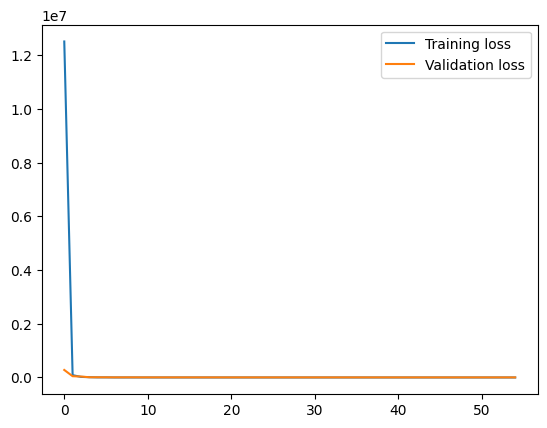

In [101]:
import matplotlib.pyplot as plt
plt.plot(losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

# Test

In [102]:
model.eval()
preds = []
actual = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs, 1)
        preds.extend(pred.tolist())
        actual.extend(labels.tolist())

In [103]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

# Convert to numpy arrays for use with sklearn
all_labels = actual
all_preds = preds

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

cm = confusion_matrix(all_labels, all_preds)
print(cm)


Accuracy: 32.43%
[[  6   4 140]
 [  6   7 140]
 [  4   6 131]]


In [82]:
df = pd.DataFrame(np.stack([all_labels, all_preds]))

In [22]:
df

,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
0,0,0,0,2,2,0,2,1,1,2,...,0,2,2,1,2,1,0,2,1,0
1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [23]:
np.unique(all_preds)

array([2])